# 前馈全连接层
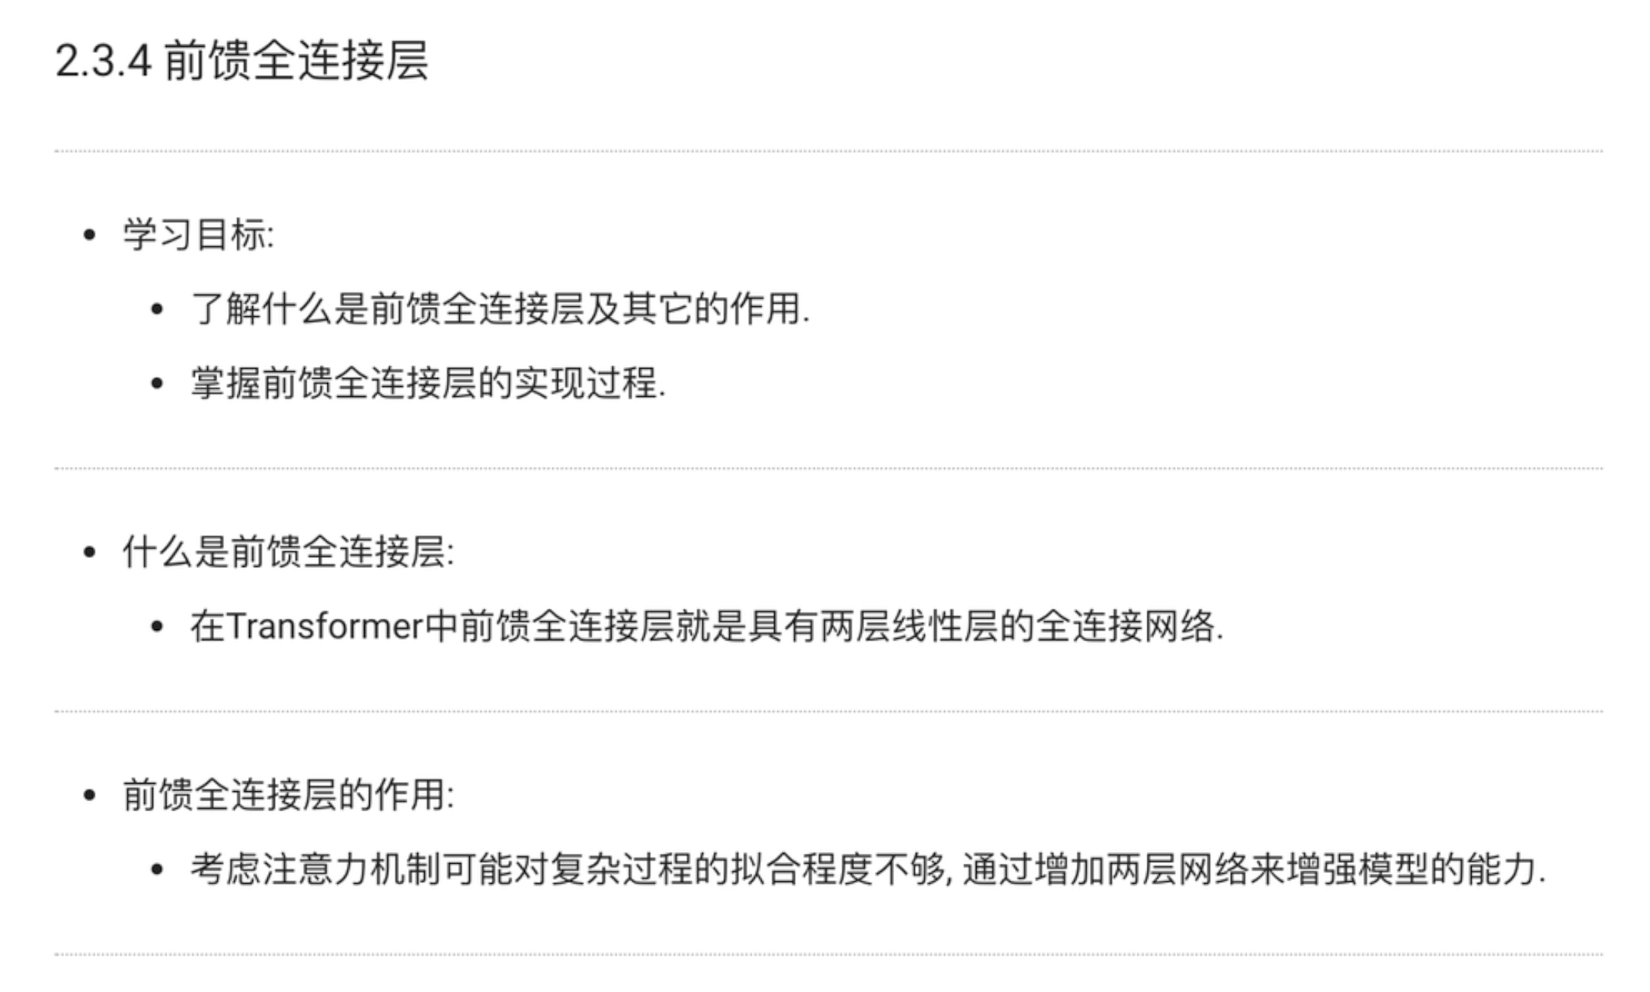

ReLU函数公式：
$ ReLU(x) = max(0,x)$

- 函数图像
 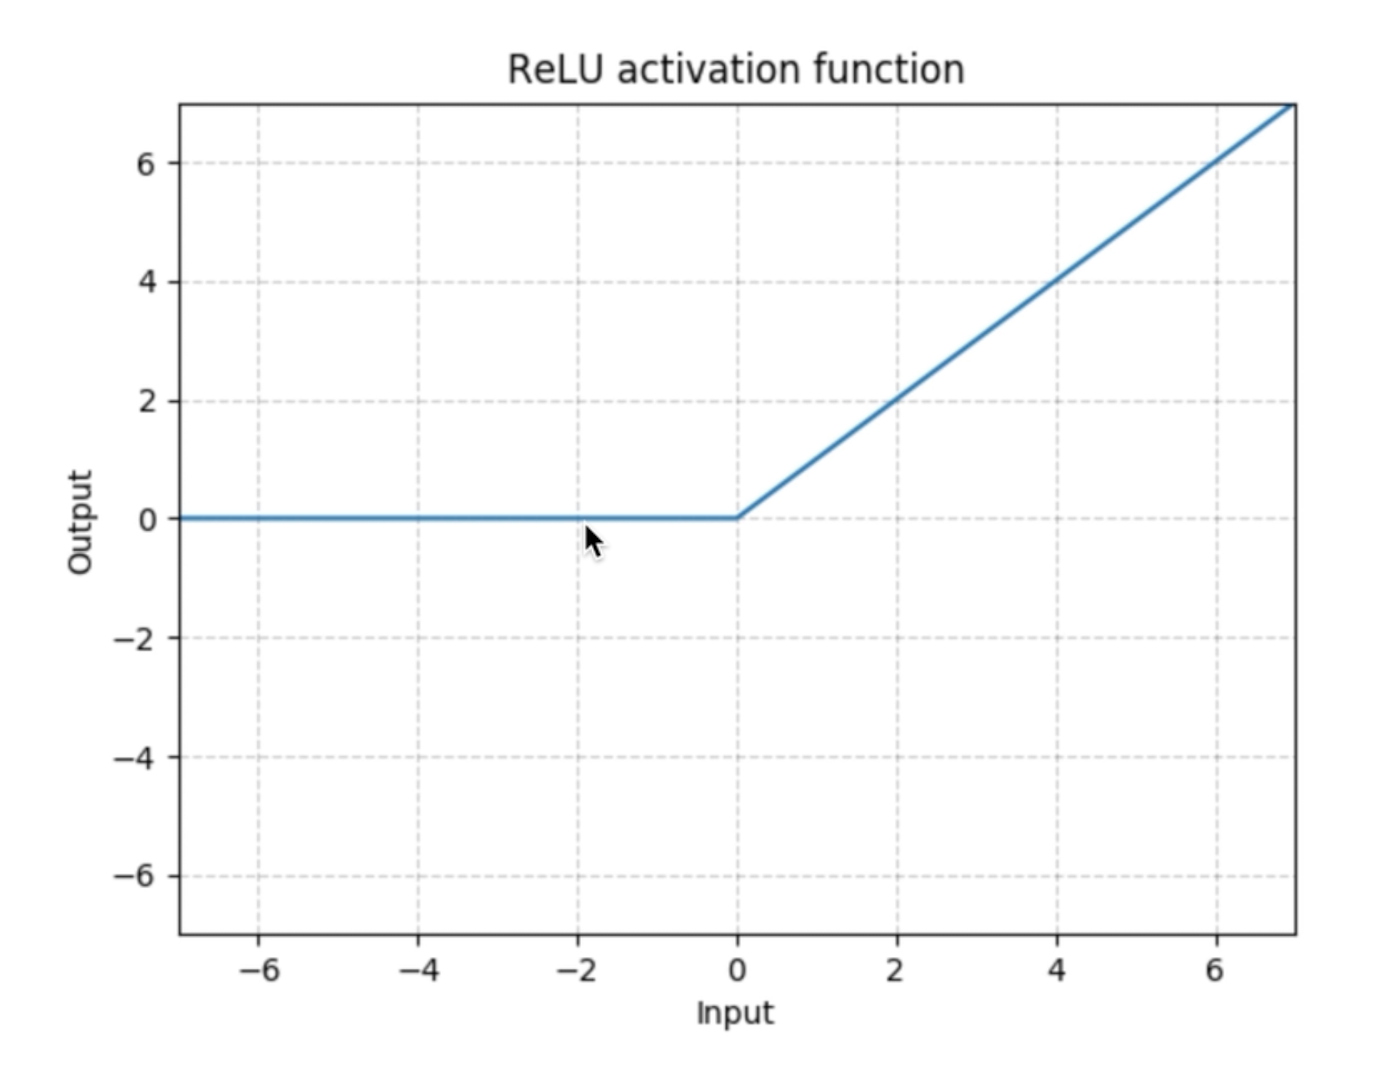

In [1]:
import copy
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.autograd import Variable

In [2]:
# 创建Embedding类来实现文本嵌入层
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        # d_model : 词嵌入的维度
        # vocab : 词表的大小
        super(Embeddings,self).__init__()
        # 定义Embedding层
        self.lut = nn.Embedding(vocab,d_model)
        # 将参数传入类中
        self.d_model = d_model
    def forward(self,x):
        # x: 代表输入进模型的文本通过词汇映射后的数字张量
        return self.lut(x) * math.sqrt(self.d_model)

In [3]:
# 位置编码层
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,dropout,max_len=5000):
        # d_model : 代表词嵌入的维度
        # dropout ： 代表Dropout 层的置零比率
        # max_len : 代表每个句子的最长长度
        super(PositionalEncoding,self).__init__()

        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len,d_model)
        position = torch.arange(0,max_len).unsqueeze(1)

        # 定义一个变化矩阵div_term,跳跃式的初始化
        div_term = torch.exp(torch.arange(0,d_model,2) * 
                             -(math.log(10000.0) / d_model))
        # 将前面定义的变化矩阵进行奇数，偶数分别赋值
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:,1::2] = torch.cos(position * div_term)

        # 将二维张量扩充成三维张量
        pe = pe.unsqueeze(0)

        # 将位置编码矩阵注册成模型的buffer，这个buffer不是模型中的参数，不跟随优化器同步更新
        # 注册成buffer后我们就可以在模型保存后重新加载的时候，将这个位置编码和模型参数一同加载进来
        self.register_buffer("pe",pe)
    def forward(self,x):
        # x:代表文本序列的词嵌入表示
        # 首先明确pe的编码太长了，将第二个维度
        # 也就是max_len对应的那个维度缩小成x的句子长度同等的长度
        x = x + Variable(self.pe[:,:x.size(1)],requires_grad=False)
        return self.dropout(x)

In [4]:
# 注意力权重的计算
def attention(query,key,value,mask=None,dropout=None):
    # query，key，value：代表注意力的三个输入张量
    # mask：掩码张量
    # dropout:传入的Dropout实例化对象
    # 首先将query的最后一个维度提取出来，代表的是词嵌入的维度
    d_k  = query.size(-1)

    # 按照注意力计算公式，将query和key的转置进行矩阵乘法，然后除以缩放系数
    scores = torch.matmul(query,key.transpose(-2,-1))/math.sqrt(d_k)

    # 判断是否使用掩码张量
    if mask is not None:
        # 利用mask_fill方法，将掩码张量和0进行位置的意义比较，如果等于0，替换成一个非常小的数
        scores = scores.masked_fill(mask == 0,-1e9)

    # 对scores的最后一个维度上进行softmax操作
    p_attn = F.softmax(scores,dim=-1)

    # 判断是否使用dropout
    if dropout is not None:
        p_attn = dropout(p_attn)

    # 最后一步完成p_attn和value张量的乘法，并返回query注意力表示
    return torch.matmul(p_attn,value),p_attn

In [5]:
# 实现深层拷贝函数，用到多个结构相同的线性层
def clones(module,N):
    # module:代表要克隆的目标网络层
    # N：将module克隆几个
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [6]:
# 实现多头注意力机制的类
class MultiHeadedAttention(nn.Module):
    def __init__(self,head,embedding_dim,dropout=0.1):
        # head:代表几个头的参数
        # embedding_dim：代表词嵌入的维度
        # dropout：进行Dropout操作时，置零的比率
        super(MultiHeadedAttention,self).__init__()

        # 要确认一个事实：多头的数量head需要整除词嵌入的维度embedding_dim
        assert embedding_dim % head == 0

        # 得到每个头获得的词向量的维度
        self.d_k = embedding_dim // head

        self.head = head
        self.embedding_dim = embedding_dim

        # 获得线性层，要获得4个，分别是Q，K，V以及最终的输出线性层
        self.linears = clones(nn.Linear(embedding_dim,embedding_dim),4)

        # 初始化注意力张量
        self.attn = None

        # 初始化dropout对象
        self.dropout = nn.Dropout(p=dropout)
    def forward(self,query,key,value,mask=None):
        # query,key,value是注意力机制的三个输入张量，mask代表掩码张量
        # 首先判断是否使用掩码张量
        if mask is not None:
            # 使用squeeze将掩码张量进行维度扩充，代表多头中的第n个头
            mask = mask.unsqueeze(0)

        # 得到batch_size
        batch_size = query.size(0)

        # 首先使用zip将网络层和输入数据连接在一起，模型的输出利用view和transpose进行维度和形状的改变
        query,key,value = \
        [model(x).view(batch_size,-1,self.head,self.d_k).transpose(1,2)
         for model,x in zip(self.linears,(query,key,value))]
        
        # 将每个头的输出传入到注意力层
        x,self.attn = attention(query,key,value,mask=mask,dropout=self.dropout)

        # 得到每个头的计算结果是4维张量，需要进行形状的转换
        # 前面已经将1,2两个维度进行过转置，在这里要重新转置回来
        # 注意：经历了transpose()方法后，必须使用contiguous方法，不然无法使用view方法
        # contiguous方法 保证 张量在内存上的地址是连续的
        x = x.transpose(1,2).contiguous().view(batch_size,-1,self.head*self.d_k)

        # 最后将x输入线性层列表中的最后一个线性层进行处理，得到最终的多头注意力结构输出
        return self.linears[-1](x)

In [7]:
# 通过类PositionwiseFeedForward来实现前馈全连接层
class PositionwiseFeedForward(nn.Module):
    def __init__(self,d_model,d_ff,dropout=0.1):
        # 初始化函数有三个输入参数分别是d_model,d_ff,和dropout=0.1
        # d_model : 线性层的输入维度也是第二个线性层的输出维度，通过前馈全连接层后输入和输出的维度不变
        # d_ff : 前馈全连接层中间隐藏层的维度，第二个线性层的输入维度和第一个线性层的输出维度
        # 这两个线性层的输入和输出维度都是 d_model，它表示了输入和输出的特征维度，这个维度通常与词嵌入的维度或者编码器输出的维度相同
        # dropout ： 置零比率
        super(PositionwiseFeedForward,self).__init__()

        # 首先按照我们预期使用nn实例化了两个线性层对象，self.w1和self.w2
        # 它们的参数分别是d_model，d_ff和 d_ff，d_model
        self.w1 = nn.Linear(d_model,d_ff)
        self.w2 = nn.Linear(d_ff,d_model)
        # 然后使用nn的Dropout实例化了对象self.dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        # 输入参数为x 代表来自上一层的输出
        # 首先经过第一个线性层，然后使用Functional中的relu函数进行激活
        # 之后再使用dropout进行随机置0，最后通过第二个线性层w2，返回最终结果
        return self.w2(self.dropout(F.relu(self.w1(x))))

In [8]:
# 实例化参数

d_model = 512
dropout = 0.1
vocab = 1000
max_len = 60

x = Variable(torch.LongTensor([[100,2,421,508],[491,998,1,221]]))
emb = Embeddings(d_model,vocab)
embr = emb(x)

x = embr
pe = PositionalEncoding(d_model,dropout,max_len)
pe_result = pe(x)

# 多头注意力的参数实例化
head=8
embedding_dim = 512
dropout = 0.2

# 若干输入参数的初始化
query = key = value = pe_result

mask = Variable(torch.zeros(8,4,4))
mha = MultiHeadedAttention(head,embedding_dim,dropout)
mha_result = mha(query,key,value,mask)

In [9]:
# 实例化参数
d_model = 512

# 线性变化的维度
d_ff = 64

dropout = 0.2

In [11]:
# 输入参数

# 输入参数x可以是多头注意力机制的输出
x = mha_result
x

tensor([[[-0.3070, -2.6453,  5.3711,  ...,  9.2483, -0.3786,  1.3295],
         [-4.3168, -3.3425,  1.1111,  ...,  9.6820, -1.2400,  0.9987],
         [ 1.7850, -4.0659, -0.5727,  ...,  7.9906, -3.8723, -1.0923],
         [ 0.0347, -4.1907,  3.7237,  ...,  7.3390, -3.9259,  8.1883]],

        [[-4.6030, -0.2058, -9.6462,  ...,  1.8584, -7.2266,  1.1189],
         [-5.4519,  0.7680, -8.1241,  ...,  1.2575, -4.3718,  2.4706],
         [-4.9829,  3.0713, -9.0828,  ...,  4.3083, -1.5900, -2.1987],
         [-3.4316,  4.4188, -6.4284,  ...,  4.4683, -0.9556,  0.7575]]],
       grad_fn=<ViewBackward0>)

In [12]:
x.shape

torch.Size([2, 4, 512])

In [14]:
# 调用
ff = PositionwiseFeedForward(d_model,d_ff,dropout)
ff_result = ff(x)
ff_result,ff_result.shape

(tensor([[[ 0.0800,  0.3983,  0.1201,  ..., -2.6635,  3.0505,  0.0427],
          [ 0.2785,  0.0299, -0.3111,  ..., -1.5433,  1.5488,  0.3705],
          [ 0.2525, -0.1974,  1.4614,  ..., -1.8522,  1.5496, -0.4342],
          [-0.0599,  0.0504,  0.8425,  ..., -2.3998,  1.2766, -0.0904]],
 
         [[-0.2301, -0.5633, -1.4790,  ..., -3.9806,  0.6905,  0.5732],
          [ 1.3250, -0.8930, -1.7272,  ..., -3.1110,  1.5707,  0.5931],
          [-0.0407, -0.4743, -1.0511,  ..., -3.0096,  1.1039, -0.6790],
          [-1.1424,  0.8699, -2.1889,  ..., -3.7251,  1.2420, -0.1911]]],
        grad_fn=<ViewBackward0>),
 torch.Size([2, 4, 512]))

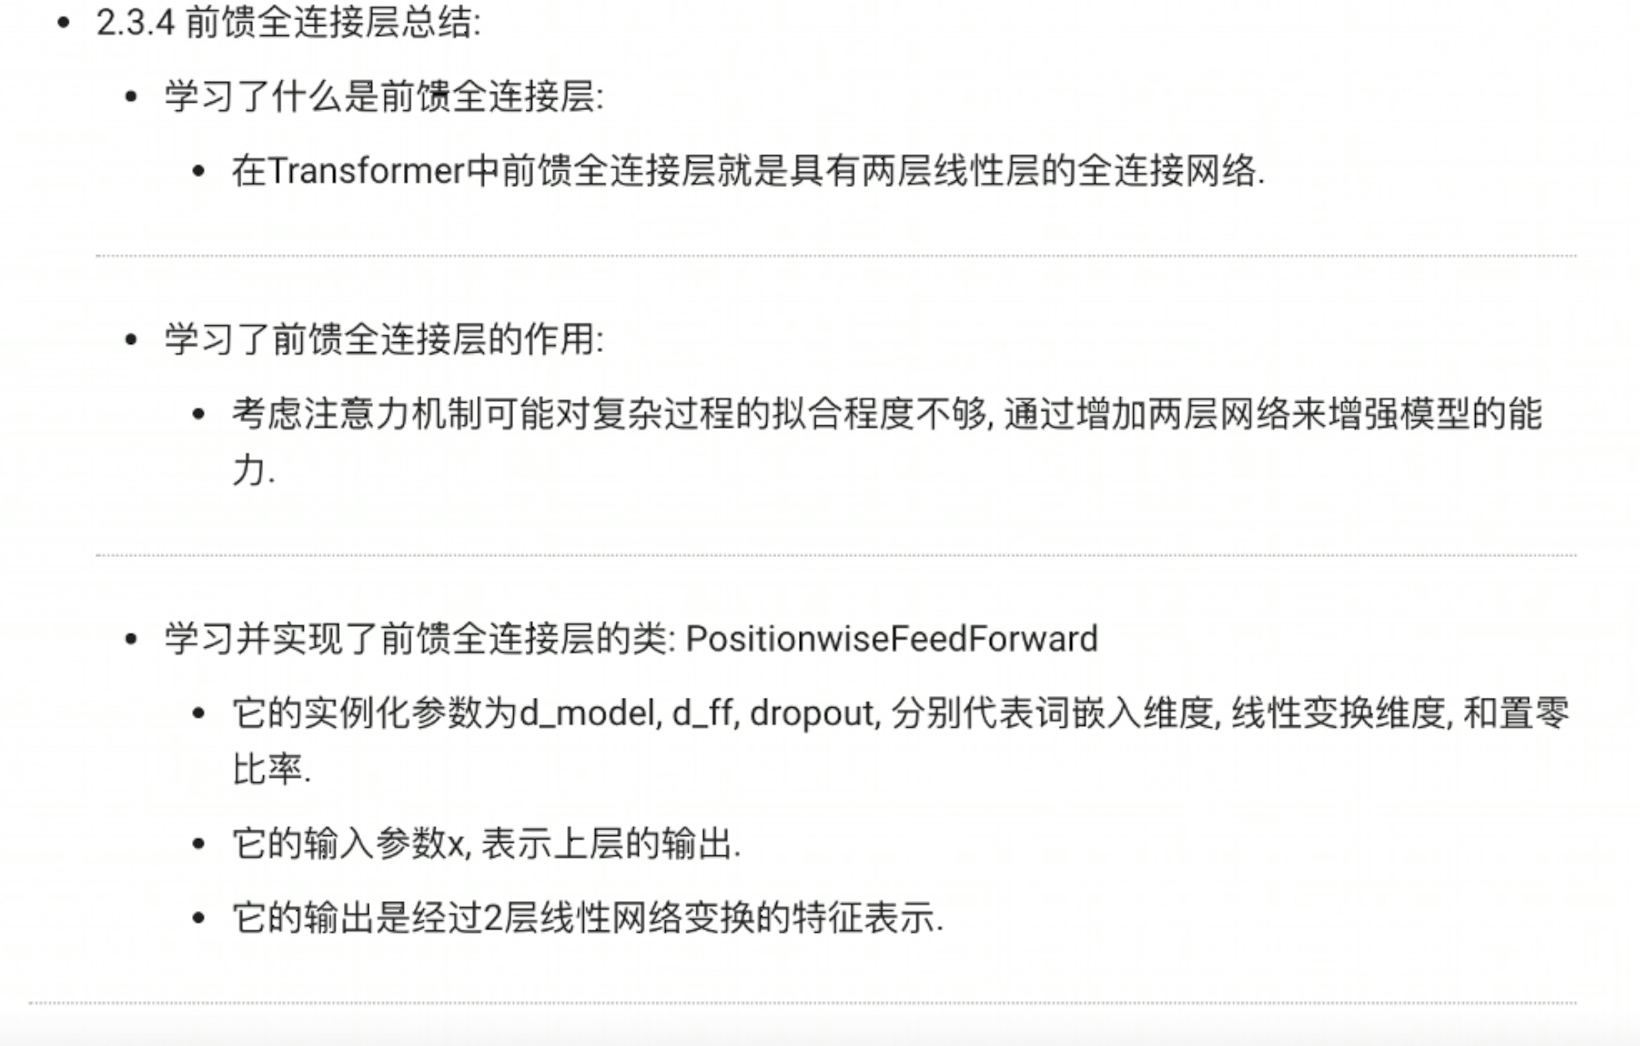